In [149]:
import subprocess
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [164]:
RUN = 44

In [165]:
# get stdout from a terminal command
def get_stdout(command):
    return subprocess.check_output(command, shell=True).decode('utf-8')

POD_TO_NODE = {}
def get_node_of_pod(podname):
    if podname in POD_TO_NODE:
        return POD_TO_NODE[podname]
    else:
        node = get_stdout("kubectl get pod " + podname + 
                   " -o jsonpath='{.spec.nodeName}'")
        POD_TO_NODE[podname] = node
        return node

In [166]:
logfilename = f"none_CPU_{RUN}"

with open(logfilename) as f:
    lines = f.readlines()
    
rows = []    
    
for line in lines:
    
    line_json = json.loads(line.strip())
    
    cpu_util = line_json["CPUUtilizations"]
    for podname in cpu_util.keys():
        if podname == "utils":
            continue
        rows.append({
            "time": float(line_json["time"])/10**9,
            "podname": podname,
            "service": podname.split("-")[0],
            "node": get_node_of_pod(podname),
            "cpu": float(cpu_util[podname]),
        })
        
df = pd.DataFrame(rows)
df["time"] = df["time"] - df["time"].min()
# df = df[df["time"] <= 30]

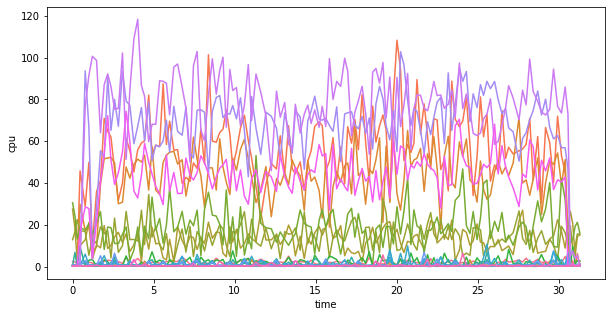

In [167]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

sns.lineplot(ax=ax, data=df, x="time", y="cpu", hue="podname")

#remove legend from ax
ax.get_legend().remove()

In [168]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "node"]).mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,podname,node,time,cpu
16,profile-788644ff68-xmjk5,minikube-m03,16.110424,79.188052
15,profile-788644ff68-r96m9,minikube-m02,16.110424,71.109487
1,frontend-7c57b66555-ddvh5,minikube-m04,16.110424,58.570166
17,recommendation-657c994fcd-j2kfr,minikube-m02,16.110424,45.393045
2,frontend-7c57b66555-fvplb,minikube-m03,16.110424,44.947635
6,hostagent-node3,minikube-m04,16.110424,19.476284
5,hostagent-node2,minikube-m03,16.110424,14.313458
4,hostagent-node1,minikube-m02,16.110424,12.889977
7,jaeger-65f6b96558-hbkj7,minikube-m03,16.110424,2.190858
0,consul-56f5cf4f78-gnr88,minikube-m03,16.110424,2.125454


In [169]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "node"]).mean().reset_index().groupby("node").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,node,time,cpu
1,minikube-m03,112.772965,144.686642
0,minikube-m02,96.662541,130.920520
2,minikube-m04,112.772965,81.844029


In [170]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "service"]).mean().reset_index().groupby("service").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,service,time,cpu
7,profile,32.220847,150.297538
1,frontend,32.220847,103.517801
3,hostagent,48.331271,46.679719
8,recommendation,16.110424,45.393045
6,mongodb,80.552118,5.286810
4,jaeger,16.110424,2.190858
0,consul,16.110424,2.125454
5,memcached,32.220847,0.638591
10,user,16.110424,0.519220
2,geo,16.110424,0.477387


In [163]:
df_grouped = df[df["time"] < 1].groupby("podname").mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,podname,time,cpu
5,hostagent-node2,0.440936,22.237284
6,hostagent-node3,0.440936,20.138807
4,hostagent-node1,0.440936,15.357302
0,consul-56f5cf4f78-gnr88,0.440936,2.289581
14,mongodb-user-7cfcc4bf4c-8wp74,0.440936,1.093408
13,mongodb-recommendation-59d6b7ccf9-zhh2d,0.440936,1.048113
16,profile-788644ff68-xmjk5,0.440936,1.008157
12,mongodb-rate-6d6d667b6-r242g,0.440936,0.998429
7,jaeger-65f6b96558-hbkj7,0.440936,0.962989
11,mongodb-profile-6bb85f4df7-5nbfn,0.440936,0.937842
